# 3. Feature Engineering and Overview

The purpose of this analysis was to explore user churn over time and get an intial feel for how much of the user base is being lost and when. How this analaysis fits in to the overall pipeline can be see below.
The functions used in this notebook were intentionally kept in a seperate PEP8 compliant python script (ct_analysis_shared_functions.py) to keep the notebook clean and a reasonable length.

##### Table of contents:

[1 Remove features that are mostly empty or artifacts of merges](#1)<br>
[2 App features](#2)<br>
[2.1 Task level](#2.1)<br>
[2.2 Task identity ](#2.2)<br>
[2.3 Number of tasks in first session](#2.3)<br>
[2.4 Sign up landing page](#2.4)<br>
[3 User signup features ](#3)<br>
[3.1 OS by device type](#3.1)<br>
[3.2 Time since injury](#3.2)<br>
[3.3 Gender](#3.3)<br>
[3.4 Disorders ](#3.4)<br>
[3.5 Deficits](#3.5)<br>
[3.6 Country](#3.6)<br>
[3.7 Age](#3.7)<br>
[4 Highly Correlated Features](#4)<br>
[5 Decide what features to remove ](#5)<br>
[6 Remove unwanted features](#6)<br>

<img src="x_figures/overview.png",width=500,height=500>

In [2]:
%matplotlib inline

# functions used in this analysis
%run x_python_scripts/ct_analysis_shared_functions.py

# Load the raw features
features = pd.read_pickle('x_data/features.pkl')

## 1 Remove features that are mostly empty or artifacts of merges <a class="anchor" id="1"></a>
No information is available for education, role, or frequence of therapy. Less than 10% of users have data available for age_group. Therefore these features were removed.<br>

*Location information*<br>
City, state, country will be highly correlated so I decided to just use country since this level probably has the biggest impact on healthcare and also most data was available for this feature of the 3 location levels.<br>

Accuracy and latency had data missing for 11.6% of users and these features were therefore excluded in the analysis. In subsequent analyses it may be worthwhile including these features.

In [3]:
#Check the number of nulls in each columns
summary = features.isnull().sum().sort_values(ascending=False)
print("% missing data by feature:")
summary[:14]/10315 *100

% missing data by feature:


education               100.000000
role                    100.000000
frequency_of_therapy    100.000000
age_group                99.970916
setting                  98.002908
city                     26.408143
state                    26.233640
latency                  11.604460
accuracy                 11.604460
gender                    3.160446
country                   0.843432
birth_year                0.029084
signup_landing_page       0.029084
subscription_status       0.019389
dtype: float64

In [4]:
#Dropped features that were sparse or non relevant.
features_to_drop = ['education','role','frequency_of_therapy','age_group',
                     'setting','city','state','accuracy','latency','subscription_status','start_date',
                   'end_date','end_date','patient_id','schedule_id','session_id','task_type_id',
                    'date(start_time)','customer_id','id_x','id_y','user_id_y','lead_source',
                    'created_date','usertype','user_id_x']

features_clean = features.drop(features_to_drop,axis=1)

#Drop the null rows in the columns we want to keep
features_clean.dropna(subset=['gender','country',
                               'birth_year','signup_landing_page'],inplace=True)

In [5]:
#QC: Check that data is clean of nulls and unwanted features
#features_clean.isnull().sum().sort_values(ascending=False)

## 2 App features <a class="anchor" id="2"></a>
### 2.1 Task level <a class="anchor" id="2.1"></a>
76% of the first session tasks were level 1 difficulty. However, 15% of the tasks were level 6 difficulty.

In [6]:
view_percent(features_clean,'task_level')
#features_clean['task_level'].value_counts().plot(kind='bar')

Number of feature classes:
5
1    76.186629
6    15.188851
2     7.675217
4     0.797819
3     0.151485
Name: task_level, dtype: float64


### 2.2 Task identity <a class="anchor" id="2.2"></a>
In total 14 of 79 tasks were introduced as the first task in the first session. The most common task assigned was the phoneme_task (70%) of first tasks.

In [7]:
view_percent(features_clean,'system_name')

Number of feature classes:
14
phoneme_tasks                        70.319127
symbol_matching_tasks                15.188851
word_coordinate_judgment_tasks        5.594829
auditory_command_tasks                2.958998
picture_memory_tasks                  2.918602
auditory_command_tasks_v2             1.777419
picture_spelling_completion_tasks     0.797819
clock_math_tasks                      0.242375
sequencing_tasks                      0.070693
functional_reading_tasks              0.060594
picture_nback_memory_tasks            0.030297
simple_word_production_tasks          0.020198
naming_picture_tasks_v3               0.010099
calendar_tasks                        0.010099
Name: system_name, dtype: float64


### 2.3 Number of tasks in first session <a class="anchor" id="2.3"></a>
Most (98.6%) of all sessions were composed of 3 tasks.

In [8]:
view_percent(features_clean,'total_task_count')

Number of feature classes:
8
3     98.626540
2      1.191678
10     0.060594
6      0.030297
0      0.030297
5      0.020198
4      0.020198
1      0.020198
Name: total_task_count, dtype: float64


### 2.4 Sign up landing page <a class="anchor" id="2.4"></a>
The most common ways that users sign up are via the v2 ipad and android sign up form. This feature was included in the analysis because the sign-up process might cause user exhaustion and pre-condition users into quitting once they get to the first task.

In [9]:
view_percent(features_clean,'signup_landing_page')

Number of feature classes:
7
/ct_signupform_v2/ipad       51.131085
/ct_signupform_v2/android    35.922036
/signup/                      6.857201
/ct_signupform_v2/iphone      6.029085
/recover                      0.030297
/RECOVER                      0.020198
/co_fb_brainpower             0.010099
Name: signup_landing_page, dtype: float64


## 3 User signup features <a class="anchor" id="3"></a>
### 3.1 OS by device type<a class="anchor" id="3.1"></a>
Most users (73%) accessed the first session on a tablet, of these 74% used ios and the rest android. Phone users mostly accessed the first session via android.

In [10]:
view_percent(features_clean,'device_form')   

Number of feature classes:
2
tablet    73.712381
phone     26.287619
Name: device_form, dtype: float64


In [11]:
#Numberof users per device and os type by counts
counts = features_clean.groupby(['device_form','os_type']).agg({'os_type': 'count'})
#and by percentage
counts.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

os_type
device_form os_type           
phone       android  76.066078
            ios      23.933922
tablet      android  25.798055
            ios      74.201945

### 3.2 Time since injury <a class="anchor" id="3.2"></a>
Nearly half of users reported that their injury took place in the last 6 months

In [12]:
view_percent(features_clean,'condition_since')

Number of feature classes:
6
6m      45.172692
1y      15.067663
5y      12.239952
2y      11.563321
>10y     9.967683
10y      5.988689
Name: condition_since, dtype: float64


### 3.3 Gender <a class="anchor" id="3.3"></a>
There were several inconsistencies in the gender variable so these were corrected. 53% of users are women,46% men and 0.69% identified as other. 

In [13]:
#replace mis-spelled gender categories
mis_spelled = ['Female','FEMALE','female','female ','Female ','Femail','F','f','female  ',
               'MALE','male','Male','Male ','male ','mald','mal','M','make','malle']
correct = (['female'] * 9) + (['male'] * 10)

features_clean.replace(to_replace=mis_spelled, value=correct, inplace=True)

view_percent(features_clean,'gender')

Number of feature classes:
3
female    52.948899
male      46.364371
OTHR       0.686730
Name: gender, dtype: float64


### 3.4 Disorders <a class="anchor" id="3.4"></a>
Users can self-report multiple disorders. Less than 1% of users self-reported: dementia, apraxia, concussion, or learning disorders. While: stroke(43%), aphasia(25%), TBI(24%), dyslexia(21%), and other brain disease(14%).

In [14]:
disorders = ['disorder: TBI',
 'disorder: Stroke',
 'disorder: Aphasia',
 'disorder: Dyslexia',
 'disorder: Dementia',
 'disorder: Apraxia',
 'disorder: Concussion',
 'disorder: Learning disorder',
 'disorder: Other brain disease',
 'disorder: Other']

for x in disorders:
    print(x)
    print("{}%".format(round((features_clean[x].value_counts(normalize=True)*100)[1],2)))

disorder: TBI
24.36%
disorder: Stroke
43.22%
disorder: Aphasia
25.88%
disorder: Dyslexia
11.04%
disorder: Dementia
21.05%
disorder: Apraxia
0.24%
disorder: Concussion
0.1%
disorder: Learning disorder
0.16%
disorder: Other brain disease
0.11%
disorder: Other
13.86%


### 3.5 Deficits <a class="anchor" id="3.5"></a>
Users can self report multiple deficits. Users reported as follows: reading 43%, writing 35%, speaking 50%,comprehension 56%, attention 63%, memory 74%,visual 43%, problem solving 65%, other 3%. Moving forward in future analyses it would be interesting to examine deficit clusters among the user base.

In [15]:
deficits = ['deficit: Reading',
 'deficit: Writing',
 'deficit: Speaking',
 'deficit: Comprehension',
 'deficit: Attention',
 'deficit: Memory',
 'deficit: Visual',
 'deficit: Problem Solving',
 'deficit: Other']

for x in deficits:
    print(x)
    print("{}%".format(round((features_clean[x].value_counts(normalize=True)*100)[1],2)))

deficit: Reading
43.92%
deficit: Writing
35.27%
deficit: Speaking
50.45%
deficit: Comprehension
56.75%
deficit: Attention
62.61%
deficit: Memory
74.88%
deficit: Visual
43.84%
deficit: Problem Solving
65.33%
deficit: Other
3.2%


In [16]:
comprehension = features_clean.groupby(['deficit: Comprehension','session_completed']).agg({'session_completed': 'count'})
print(comprehension)

#Show results as percentage
comprehension.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

                                          session_completed
deficit: Comprehension session_completed                   
0                      0                                796
                       1                               3487
1                      0                                999
                       1                               4620


session_completed
deficit: Comprehension session_completed                   
0                      0                          18.585104
                       1                          81.414896
1                      0                          17.778964
                       1                          82.221036

In [17]:
visual = features_clean.groupby(['deficit: Visual','session_completed']).agg({'session_completed': 'count'})
print(visual)
#Show results as percentage
visual.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

                                   session_completed
deficit: Visual session_completed                   
0               0                               1028
                1                               4533
1               0                                767
                1                               3574


session_completed
deficit: Visual session_completed                   
0               0                          18.485884
                1                          81.514116
1               0                          17.668740
                1                          82.331260

### 3.6 Country <a class="anchor" id="3.6"></a>
Most users (71.5%) are based in the US. Only 5% are based in countries were English is not the national language

In [18]:
#Reduce the 102 countries to top 8 most frequent countries which are all english speaking and bin the rest 
#into 'Non-english speaking countries'
keep = ['United States','United Kingdom', 'Canada', 'Australia', 
           'India', 'Ireland', 'New Zealand', 'South Africa']

features_clean['country'] = [x if x in keep else 
                              'Non-English-Speaking'for x in features_clean['country']]

view_percent(features_clean,'country')

Number of feature classes:
9
United States           71.480509
United Kingdom           8.856797
Canada                   6.695617
Non-English-Speaking     5.009089
Australia                3.463947
India                    2.363159
Ireland                  0.888709
New Zealand              0.787720
South Africa             0.454454
Name: country, dtype: float64


### 3.7 Age <a class="anchor" id="3.7"></a>

First lets compare the age distributions of users who completed the first session vs users who did not.

In [19]:
#Translate birth_year to age in years to make more clear
features_clean['age'] = features_clean['birth_year'].apply(lambda x: 2017- x)

#Comparison of age between users who completed the first session (1) and users who did not (0)
features_clean.groupby(['session_completed']).agg({'age': 'describe'})

age
session_completed                   
0                 count  1795.000000
                  mean     57.742618
                  std      21.298001
                  min       3.000000
                  25%      44.000000
                  50%      62.000000
                  75%      73.500000
                  max     112.000000
1                 count  8107.000000
                  mean     54.666214
                  std      19.635837
                  min       3.000000
                  25%      41.000000
                  50%      57.000000
                  75%      69.000000
                  max     117.000000

The age distribution between those that complete first session and those who do not is significantly different

In [20]:
test =features_clean[['age','session_completed']]

completed_yes = test.loc[test['session_completed']== 1]
completed_no = test.loc[test['session_completed']== 0]

completed_no_mat = completed_no['age'].as_matrix()
completed_yes_mat = completed_yes['age'].as_matrix()

#T-test (from scipy); the first value is t-statistic, the second is the two-tailed p-value 
stats.ttest_ind(completed_no_mat,completed_yes_mat)

Ttest_indResult(statistic=5.9123438375384909, pvalue=3.4842395686636218e-09)

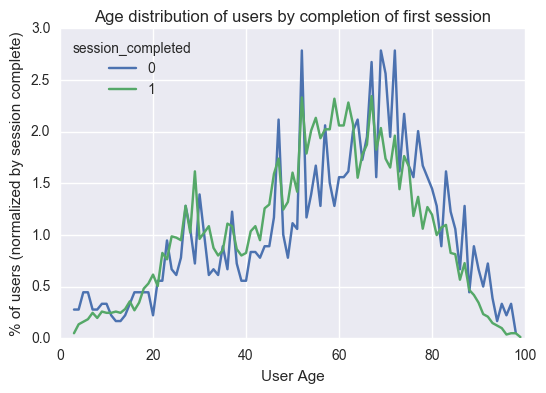

In [21]:
data_to_plot = features_clean.groupby(['age','session_completed']).agg({'session_completed': 'count'})
age_data = data_to_plot.sort_index()
age_data1 = age_data.unstack()['session_completed']
age_data1[0] = age_data1[0].apply(lambda x:100 * x/age_data1[0].sum())
age_data1[1] = age_data1[1].apply(lambda x:100 * x/age_data1[1].sum())

ax =age_data1.plot()
ax.set_xlabel('User Age')
ax.set_ylabel('% of users (normalized by session complete)')

title_string = 'Age distribution of users by completion of first session'

ax.set_title('Age distribution of users by completion of first session', fontsize=12)

ax.set_xlim(0,100);
plt.savefig('x_figures/3_feature_engineering/age_distribution.jpg')

In [22]:
#Delete features we don need and save the cleaned features
features_clean.pop('deficits: 999')
features_clean.pop('completed_task_count')
features_clean.pop('birth_year')
print('features removed')

features removed


## 4 Highly correlated features <a class="anchor" id="4"></a>

Looking at a heat map of the of the correlation matrix we see that several of the features are highly correlated.

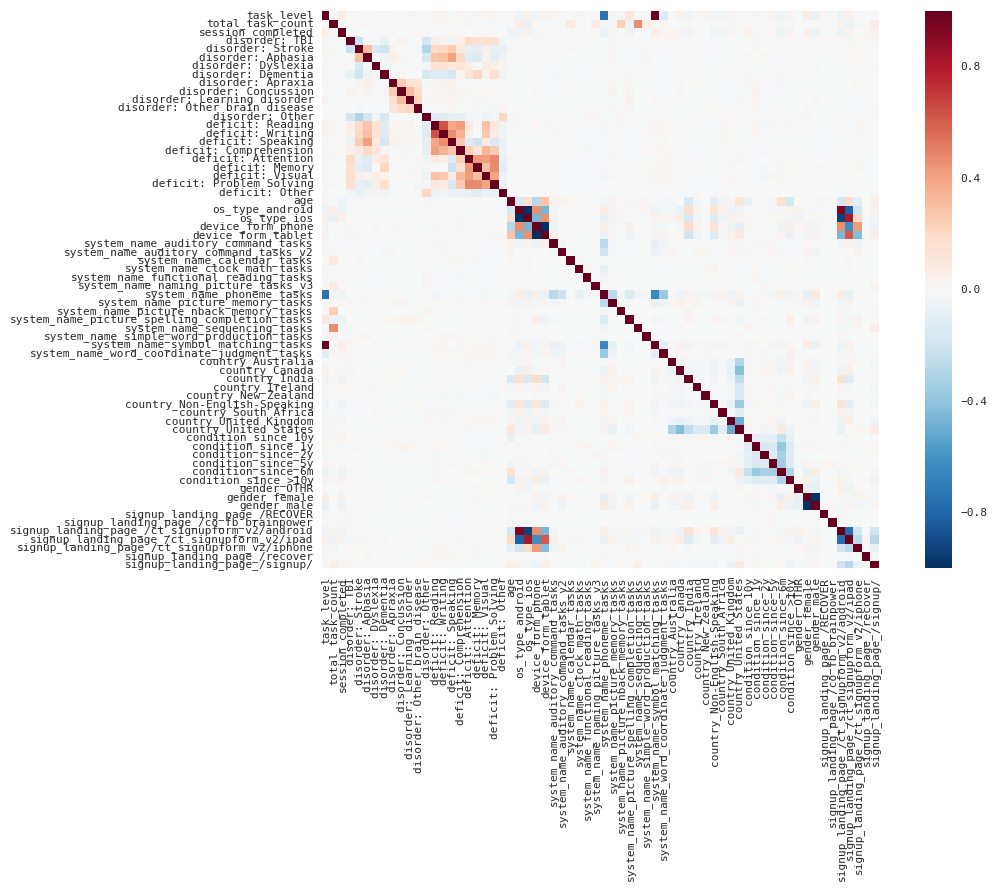

In [23]:
heat_map(features_clean);
plt.savefig('x_figures/3_feature_engineering/feature_similarity.jpg')

Below we see the top 10 feature correlations in descending order. The rows with self-correlation have been removed for clarity.

Both os_type (ios or android) and device type (phone or tablet) are binary features so we can keep one of each feature after dummy encoding. For example os_type_android = 0 means that it is os_type_ios. Likewise device_form_tablet = 0 means that it is device_form_phone.

Gender is near binary (with the exception of 0.69% identifying as other. This might be worth making a binary feature. 

In [24]:
#Dataframe of top 10 absolute values of feature-feature correlation
out = corr_dataframe(features_clean)
out[:10]

,level_0,level_1,correlation
1741,device_form_tablet,device_form_phone,-1.000000
1676,device_form_phone,device_form_tablet,-1.000000
1607,os_type_ios,os_type_android,-1.000000
1542,os_type_android,os_type_ios,-1.000000
3820,gender_female,gender_male,-0.986300
3885,gender_male,gender_female,-0.986300
39,task_level,system_name_symbol_matching_tasks,0.977620
2574,system_name_symbol_matching_tasks,task_level,0.977620
4049,signup_landing_page_/ct_signupform_v2/android,os_type_android,0.931405
1579,os_type_android,signup_landing_page_/ct_signupform_v2/android,0.931405


## 5 Decide what features to remove <a class="anchor" id="5"></a>

The function below allows you to play around and test how removing features influences the importance of the remaining features and the accuracy of the random forest model (see modelling notebook for how the classifier was selected).

The feature_importance function scales and oversamples the training set using SMOTE as outlined in the modelling notebook.

In [25]:
feature_importance(features_clean,['device_form_phone','os_type_ios'])

Accuracy:
0.859
Feature ranking:
1. feature age (0.104153)
2. feature condition_since_6m (0.049628)
3. feature deficit: Comprehension (0.038717)
4. feature disorder: Stroke (0.038053)
5. feature deficit: Visual (0.036561)
6. feature deficit: Attention (0.034583)
7. feature disorder: TBI (0.034155)
8. feature deficit: Speaking (0.032853)
9. feature deficit: Writing (0.031515)
10. feature deficit: Reading (0.031394)
11. feature disorder: Aphasia (0.031339)
12. feature deficit: Problem Solving (0.031263)
13. feature gender_male (0.030863)
14. feature gender_female (0.029735)
15. feature deficit: Memory (0.028936)
16. feature country_United States (0.028859)
17. feature disorder: Dementia (0.027497)
18. feature device_form_tablet (0.025316)
19. feature system_name_phoneme_tasks (0.022461)
20. feature condition_since_1y (0.022420)
21. feature disorder: Other (0.020441)
22. feature signup_landing_page_/ct_signupform_v2/android (0.019889)
23. feature condition_since_5y (0.018989)
24. feature 

## 6 Remove the unwanted features <a class="anchor" id="6"></a>
Once you have played around with different feature sets and settled on a specific set. Remove the unwanted features from the cleaned features dummy encoded dataframe and save the output as a pickle. This performance of the classifier with the given feature set can then be explored further inthe modelling notebook.

In [26]:
#Make a copy of cleaned features dataframe
df = pd.get_dummies(features_clean.copy())

# Remove unwanted features from the features dataframe
dropped_features = ['device_form_phone','os_type_ios']
final_features = df.drop(dropped_features, axis=1)

#Save final cleaned features as a pickle
final_features.to_pickle("x_data/final_features.pkl")